In [4]:
from datasets import load_dataset, DatasetDict, Dataset # Import dataset import function for hugging face
dataset:DatasetDict = load_dataset("surrey-nlp/PLOD-CW") # import the coursework dataset from

In [2]:
# Training usage https://spacy.io/usage/training

In [59]:
train_dict = dataset["train"]
train_tokens = train_dict["tokens"]
train_pos_tags = train_dict["pos_tags"]
train_ner_tags = train_dict["ner_tags"]

validation_dict = dataset["validation"]
validation_tokens = validation_dict["tokens"]
validation_pos_tags = validation_dict["pos_tags"]
validation_ner_tags = validation_dict["ner_tags"]

test_dict = dataset["test"]
test_tokens = test_dict["tokens"]
test_pos_tags = test_dict["pos_tags"]
test_ner_tags = test_dict["ner_tags"]

def flatten_list(given_list:list[list[any]]) -> list[any]:
    return [element for inner_list in given_list for element in inner_list]

def data_to_lower(data:list[list[str]]) -> list[list[str]]:
    return [[token.lower() for token in tokens] for tokens in data]

train_tokens = data_to_lower(train_tokens)
validation_tokens = data_to_lower(validation_tokens)
test_tokens = data_to_lower(test_tokens)

class DataItem:
    def __init__(self, tokens, pos, ner, idx=0):
        self.idx=idx
        self.tokens:list[str] = tokens
        self.pos:list[str] = pos
        self.ner:list = ner

class DataCollection:
    def __init__(self, data_collection:list[DataItem], max_token_length=512):
        self.max_token_length = max_token_length
        self.data_collection:list[DataItem] = data_collection
        self.unique_tags = self.get_unique_tags()
        self.item_embeddings:dict = self.create_item_embeddings(self.unique_tags)
        self.reverse_embeddings:dict = {v:k for k,v in self.item_embeddings.items()}

    def get_token_list(self) -> list[list[str]]:
        return [data_item.tokens for data_item in self.data_collection]

    def get_pos_list(self) -> list[list[str]]:
        return [data_item.pos for data_item in self.data_collection]

    def get_ner_list(self) -> list[list[str]]:
        return [data_item.ner for data_item in self.data_collection]
    
    def get_ner_idx_list(self) -> list[list[str]]:
        ner_idx_list_collection = []
        for data_item in self.data_collection:
            ner_idx_list = []
            for ner_tag in data_item.ner:
                ner_idx_list.append(self.item_embeddings[ner_tag])
            ner_idx_list_collection.append(ner_idx_list)
        return ner_idx_list_collection

    
    def get_unique_tags(self) -> list[str]:
        return list(set(flatten_list(self.get_ner_list())))
    
    def create_item_embeddings(self, tags:list[str]) -> dict:
        return {label:idx for idx, label in enumerate(tags)}
    
    def get_tag_count(self) -> dict:
        tag_dict = {}
        for tag_list in self.get_ner_list():
            for tag in tag_list:
                if tag not in tag_dict.keys():
                    tag_dict[tag] = 1
                else:
                    tag_dict[tag] += 1
        return tag_dict

def dataset_to_collection(dataset:Dataset) -> DataCollection:
    data_items:list[DataItem] = []
    for idx in range(dataset.num_rows):
        data_items.append(DataItem(dataset["tokens"][idx], dataset["pos_tags"][idx], dataset["ner_tags"][idx], idx))
    return DataCollection(data_items)

train_data:list[DataItem] = []
for idx in range(len(train_tokens)):
    train_data.append(DataItem(train_tokens[idx], train_pos_tags[idx], train_ner_tags[idx], idx))
train_collection:DataCollection = DataCollection(train_data)

validation_data:list[DataItem] = []
for idx in range(len(validation_tokens)):
    validation_data.append(DataItem(validation_tokens[idx], validation_pos_tags[idx], validation_ner_tags[idx], idx))
validation_collection:DataCollection = DataCollection(validation_data)

test_data:list[DataItem] = []
for idx in range(len(test_tokens)):
    test_data.append(DataItem(test_tokens[idx], test_pos_tags[idx], test_ner_tags[idx], idx))
test_collection:DataCollection = DataCollection(test_data)

In [6]:
# python
import os
import pandas as pd
import numpy as np
import string  

# spacy
import spacy
from spacy.tokens import Span
from spacy.language import Language
from spacy.tokens import Doc, DocBin
nlp:Language = spacy.blank("en")

# configuration
def create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

working_dir:str = os.getcwd()
vocab_dir:str = os.path.join(working_dir, "spacy_vocab")
create_dir(vocab_dir)

config_dir:str = os.path.join(working_dir, "config")
create_dir(config_dir)

output_dir:str = os.path.join(working_dir, "output")
create_dir(output_dir)

train_vocab_path = os.path.join(vocab_dir, "train.spacy")
dev_vocab_path = os.path.join(vocab_dir, "dev.spacy")
config_path = os.path.join(config_dir, "config.cfg")


In [7]:
train_docbin:DocBin = DocBin()
test_docbin:DocBin = DocBin()

def dataset_to_vocab(collection:DataCollection, doc_bin:DocBin) -> dict:
    for data_item in collection.data_collection:
        spaces = [True if token not in string.punctuation else False for token in data_item.tokens] 
        doc = Doc(nlp.vocab, words=data_item.tokens, spaces=spaces, ents=data_item.ner)
        doc_bin.add(doc)

dataset_to_vocab(train_collection, train_docbin)
dataset_to_vocab(test_collection, test_docbin)

train_docbin.to_disk(train_vocab_path)
test_docbin.to_disk(dev_vocab_path)

In [ ]:
# from spacy.cli.train import train

# train(config_path=config_path, output_path=output_dir, overrides={"paths.train": train_vocab_path, "paths.dev": dev_vocab_path}, use_gpu=0)

ℹ Saving to output directory:
c:\Users\olive\OneDrive\Documents\Uni\COM3029 - NLP\cw\spacy\output
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['transformer', 'ner']
ℹ Initial learn rate: 0.0
E    #       LOSS TRANS...  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  -------------  --------  ------  ------  ------  ------
  0       0        5584.67    866.56    0.50    2.46    0.28    0.00
  7     200      134885.64  67008.82   92.29   93.96   90.69    0.92
 14     400        6795.98  10354.62   92.54   93.66   91.45    0.93
 22     600        1644.44   2583.32   92.21   93.85   90.62    0.92
 30     800         761.92   1126.84   91.78   92.99   90.60    0.92
 37    1000         545.64    794.82   92.29   93.88   90.75    0.92
 45    1200         409.84    585.76   92.14   93.72   90.60    0.92
 52    1400         271.97    379.20   92.64   93.69   91.62    0.93
 60    1600         307.55    456.88   92.57   93.83   91.34    0.93
 67    1800         373.42    485.84   92.57   94.16   91.03    0.93
 75    20

In [8]:
from spacy import displacy
best_model_nlp:Language = spacy.load("./output/model-best")

C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [44]:
class EntSpan:
    def __init__(self, text, label):
        self.text = text
        self.label = label

def ents_to_len(ents) -> tuple[int, list[EntSpan]]:
    tok_len = 0
    for ent in ents:
        if len(ent.text) > 1:
            ent_tokens = ent.text.split(" ")
            tok_len += len(ent_tokens)
        else:
            tok_len += 1
    return tok_len

def ent_to_entspan(ents) -> list[EntSpan]:
    span_list:list[EntSpan] = []
    for ent in ents:
        if len(ent.text) > 1: # handle multiple tokens split
            ent_tokens = ent.text.split(" ")
            if ent.label_ == "LF": # handle LF split
                for idx, tok in enumerate(ent_tokens):
                    if idx == 0:
                        span_list.append(EntSpan(tok, ("B-"+str(ent.label_))))
                    else:
                        span_list.append(EntSpan(tok, ("I-"+str(ent.label_))))
            else:
                for tok in ent_tokens:
                    span_list.append(EntSpan(tok, ("B-"+str(ent.label_))))
        else:
            span_list.append(EntSpan(ent.text, ("B-"+str(ent.label_))))

    return span_list

def pad_ents(tokens:list[str], ents) -> list[EntSpan]:
    span_list:list[EntSpan] = ent_to_entspan(ents)
    invalid_token = "inv" # for ease of use to change what is invalid token naming convention

    for idx in range(len(tokens)):
        if tokens[idx] != span_list[idx].text:
            span_list.insert(idx, EntSpan(tokens[idx], invalid_token))

    return span_list

def pad_tokens(tokens:list[str], ner_tags:list[str], ents) -> list[str]: # need to pad tokens, as
    span_list:list[EntSpan] = ent_to_entspan(ents)
    token_list:list[EntSpan] = []
    invalid_token = "inv"

    next_token:str = str(span_list[0].text) # set it to first token!
    token_idx = 0
    invalid_tok = False
    for idx in range(len(span_list)):
        if tokens[token_idx] != span_list[idx].text:
            if tokens[token_idx] != next_token and invalid_tok: # second part is to avoid overriding the first value!
                # print("Mid Invalid")
                next_token += str(span_list[idx+1].text) # append prev
                # print(f"[{tokens[token_idx]}] | [{span_list[idx].text}] | [{next_token}]")
                token_list.insert(idx, EntSpan(invalid_token, invalid_token))
            elif tokens[token_idx] == next_token:
                # print("Final invalid")
                # print(f"[{tokens[token_idx]}] | [{span_list[idx].text}] | [{next_token}]")
                token_list.insert(idx, EntSpan(invalid_token, invalid_token))
                token_idx += 1
                next_token = str(span_list[idx].text) # clear prev
                invalid_tok = False
            else:
                # print("First Invalid")
                # print(f"[{tokens[token_idx]}] | [{span_list[idx].text}] | [{next_token}]")
                token_list.insert(idx, EntSpan(tokens[token_idx], ner_tags[token_idx]))
                next_token += str(span_list[idx+1].text) # clear prev
                invalid_tok = True
        else:
            # print("Valid")
            # print(f"[{tokens[token_idx]}] | [{span_list[idx].text}] | [{next_token}]")
            if idx == 0:
                next_token = span_list[idx].text
            elif idx < len(span_list)-1:
                next_token = span_list[idx+1].text
            else:
                next_token = ""
            token_list.insert(idx, EntSpan(tokens[token_idx], ner_tags[token_idx]))
            token_idx += 1
    # print("TO:", tokens)
    # print("TL:", token_list)
    # print("PR:", [str(ent.text) for ent in ents])
    return token_list

def lists_to_metrics(token_list:list[EntSpan], span_list:list[EntSpan]) -> list[str]:
    list_values:list[str] = []
    for idx in range(len(token_list)):
        list_values.append([token_list[idx].text, token_list[idx].label, span_list[idx].label])
    return list_values

def collection_to_predictions(data_collection:DataCollection):
    validation_token_list = data_collection.get_token_list()
    validation_ner_list = data_collection.get_ner_list()

    metrics:list[list[str]] = [] # token, true, predicted
    for validation_idx in range(len(data_collection.data_collection)):
        token_list_iter:list[str] = validation_token_list[validation_idx]
        ner_tag_list_iter:list[str] = validation_ner_list[validation_idx]
        
        sent = " ".join(token_list_iter)
        doc:Doc = best_model_nlp(sent)

        current_token_len:int = len(token_list_iter)
        current_ent_len = ents_to_len(doc.ents)
        
        if(current_token_len != current_ent_len):
            if current_token_len > current_ent_len: # pad entities
                tokens_list:list[EntSpan] = []
                for tok, ner in zip(token_list_iter, ner_tag_list_iter):
                    tokens_list.append(EntSpan(tok, ner)) 
                span_list:list[EntSpan] = pad_ents(token_list_iter, doc.ents)
            else: # pad tokens
                span_list:list[EntSpan] = ent_to_entspan(doc.ents)
                tokens_list:list[EntSpan] = pad_tokens(token_list_iter, ner_tag_list_iter, doc.ents)
                # print(validation_idx, " Tokens Padded Successfully!")
            
            if(len(tokens_list) != len(span_list)):
                print(validation_idx, " IDX does not match: ", current_token_len, " | ", current_ent_len)
            else:
                print(validation_idx, " IDX was padded to match! Span Len: ", len(span_list), " | Tok Len: ", len(tokens_list))
            
            metrics.append(lists_to_metrics(tokens_list, span_list))
        else:
            tokens_list:list[EntSpan] = []
            for index in range(current_token_len):
                tokens_list.append(EntSpan(token_list_iter[index], ner_tag_list_iter[index]))
            metrics.append(lists_to_metrics(tokens_list, ent_to_entspan(doc.ents)))
    return metrics


metrics = collection_to_predictions(validation_collection)
print(metrics)

25  IDX was padded to match! Span Len:  40  | Tok Len:  40
32  IDX was padded to match! Span Len:  50  | Tok Len:  50
47  IDX was padded to match! Span Len:  67  | Tok Len:  67
68  IDX was padded to match! Span Len:  22  | Tok Len:  22
83  IDX was padded to match! Span Len:  35  | Tok Len:  35
96  IDX was padded to match! Span Len:  35  | Tok Len:  35
110  IDX was padded to match! Span Len:  8  | Tok Len:  8
124  IDX was padded to match! Span Len:  38  | Tok Len:  38
[[['=', 'B-O', 'B-O'], ['manual', 'B-LF', 'B-LF'], ['ability', 'I-LF', 'I-LF'], ['classification', 'I-LF', 'I-LF'], ['system', 'I-LF', 'I-LF'], [';', 'B-O', 'B-O'], ['quest', 'B-AC', 'B-AC'], ['=', 'B-O', 'B-O'], ['quest', 'B-LF', 'B-LF'], ['-', 'I-LF', 'I-LF'], ['quality', 'I-LF', 'I-LF'], ['of', 'I-LF', 'I-LF'], ['upper', 'I-LF', 'I-LF'], ['extremity', 'I-LF', 'I-LF'], ['skills', 'I-LF', 'I-LF'], ['test', 'I-LF', 'I-LF'], [';', 'B-O', 'B-O'], ['cont', 'B-O', 'B-AC'], ['=', 'B-O', 'B-O'], ['control', 'B-O', 'B-O'], [';', 

In [46]:
flat_list = []
for metric_list in metrics:
    for metric_item in metric_list:
        flat_list.append(metric_item)

metric_df = pd.DataFrame(flat_list, columns=['Tokens', 'Tags', "Predicted Tags"])

tags = validation_collection.get_unique_tags()
tags.append("inv")
result_df = pd.DataFrame(0, columns=tags, index=tags)

from tqdm import tqdm

for item in tqdm(flat_list):
    tag = item[1]
    predicted_tag = item[2]
    result_df.at[tag, predicted_tag] += 1
result_df.to_csv('result.csv', index=False)
result_df

100%|██████████| 5003/5003 [00:00<00:00, 61259.23it/s]


,I-LF,B-O,B-AC,B-LF,inv
I-LF,278,39,0,8,2
B-O,64,4111,46,33,7
B-AC,3,51,207,2,0
B-LF,7,22,0,120,0
inv,0,2,1,0,0


{'B-O': 4261, 'B-LF': 149, 'I-LF': 327, 'B-AC': 263}
Sum of each row:
I-LF     327
B-O     4261
B-AC     263
B-LF     149
inv        3
dtype: int64
          I-LF       B-O      B-AC      B-LF       inv
I-LF  0.850153  0.119266  0.000000  0.024465  0.006116
B-O   0.015020  0.964797  0.010796  0.007745  0.001643
B-AC  0.011407  0.193916  0.787072  0.007605  0.000000
B-LF  0.046980  0.147651  0.000000  0.805369  0.000000
inv   0.000000  0.666667  0.333333  0.000000  0.000000


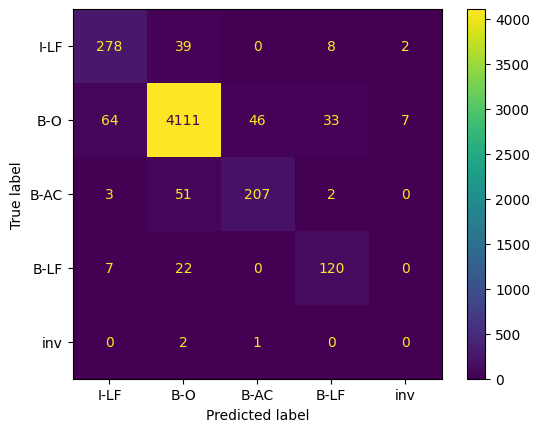

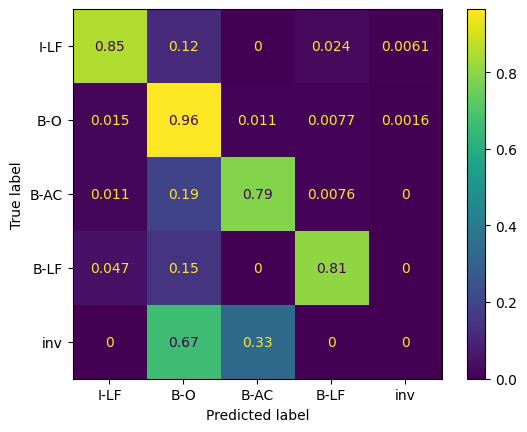

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay

from matplotlib import pyplot as plt

print(validation_collection.get_tag_count())

sum_rows = result_df.sum(axis=1)
print(f"Sum of each row:\n{sum_rows}")

normalized_result_df = result_df.div(result_df.sum(axis=1), axis=0)
print(normalized_result_df)

disp = ConfusionMatrixDisplay(confusion_matrix=result_df.to_numpy(), display_labels=tags) 
# Then just plot it: 
disp.plot() 
# And show it: 
plt.show()

normalized_disp = ConfusionMatrixDisplay(confusion_matrix=normalized_result_df.to_numpy(), display_labels=tags)
normalized_disp.plot()
plt.show()

In [10]:
# text = " ".join(validation_collection.get_token_list()[0])
# doc:Doc = best_model_nlp(text)

predicted_tags = []
validation_token_list = validation_collection.get_token_list()
for validation_idx, tokens in enumerate(validation_token_list):
    sent = " ".join(tokens)
    doc:Doc = best_model_nlp(sent)
    tag_counter = 0
    et = []
    for ent in doc.ents:
        if len(ent.text) > 1: # handle multiple tokens split
            ent_tokens = ent.text.split(" ")
            if ent.label_ == "LF": # handle LF split
                for idx, tok in enumerate(ent_tokens):
                    if idx == 0:
                        # print(str(tok)+" | B-"+str(ent.label_))
                        predicted_tags.append("B-"+str(ent.label_))
                        tag_counter += 1
                        et.append(str(tok))
                    else:
                        # print(str(tok)+" | I-"+str(ent.label_))
                        predicted_tags.append("I-"+str(ent.label_))
                        tag_counter += 1
                        et.append(str(tok))
            else:
                for tok in ent_tokens:
                    # print(str(tok)+" | B-"+str(ent.label_))
                    predicted_tags.append("B-"+str(ent.label_))
                    tag_counter += 1
                    et.append(str(tok))
        else:            
            # print(str(ent.text)+" | B-"+str(ent.label_))
            predicted_tags.append("B-"+str(ent.label_))
            tag_counter += 1
            et.append(str(ent))
    if len(tokens) != tag_counter:
        print("Tokens at IDX ", validation_idx, " DO NOT ALIGN!")
        print("Expected Length: ", len(tokens), " | Predicted Length: ", tag_counter)
        print(len(tokens), "_T_LOG: ", tokens)
        print(len(et), "_E_LOG: ", et)
    # break

true_tags = flatten_list(validation_collection.get_ner_list())
token_list = flatten_list(validation_collection.get_token_list())

print("TOKEN LEN: ", len(token_list))
print("TAG LEN: ", len(true_tags))
print("PREDICT TAG LEN: ", len(predicted_tags))

data = []
for idx in range(token_list):
    data.append([token_list[idx], true_tags[idx], predicted_tags[idx]])

result_df = pd.DataFrame(data, columns=['Tokens', 'Tags', "Predicted Tags"])
result_df.to_csv('result.csv', index=False)
result_df

Tokens at IDX  25  DO NOT ALIGN!
Expected Length:  40  | Predicted Length:  37
40 _T_LOG:  ['members', 'of', 'the', 'plant', 'heme', 'activator', 'protein', '(', 'hap', ')', 'or', 'nuclear', 'factor', 'y', '(', 'nf', '-', 'y', ')', 'are', 'trimeric', 'transcription', 'factor', 'complexes', 'composed', 'of', 'the', 'nf', '-', 'ya', ',', 'nf', '-', 'yb', 'and', 'nf', '-', 'yc', 'subfamilies', '.']
37 _E_LOG:  ['members', 'of', 'the', 'plant', 'heme', 'activator', 'protein', '(', 'hap', ')', 'or', 'nuclear', 'factor', 'y', '(', 'nf', 'y', ')', 'are', 'trimeric', 'transcription', 'factor', 'complexes', 'composed', 'of', 'the', 'nf', '-', 'ya', ',', 'nf', 'yb', 'and', 'nf', 'yc', 'subfamilies', '.']
Tokens at IDX  32  DO NOT ALIGN!
Expected Length:  50  | Predicted Length:  49
50 _T_LOG:  ['ep', ':', 'group', ':', 'extra', '-', 'perigastric', 'lymph', 'node', 'group', 'a', 'recent', 'result', 'from', 's.', 'pombe', 'suggests', 'that', 'in', 'this', 'organism', ',', 'in', 'which', 'all', 'co

TypeError: 'list' object cannot be interpreted as an integer